# Assignment 3

## Question 1

### Importing packages and setting the directories

In [2]:
from statsmodels.formula.api import ols
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import quantecon as qe

os.chdir("/Users/buzunonat/Desktop/inequality/Assignment 3")
df=pd.read_stata("/Users/buzunonat/Desktop/inequality/Assignment 3/psid1999.dta")


### Question 1.1

Basic regression to estimate some coefficients



In [3]:
#df=df.query("age>24 & age<66  & head_hrs >0 & relationhead==10 & totcons>0")
df["mls"]=df["mls"].astype("string")
df=df[df['mls']!="NA"] # Dropping NA values
df=df.query("age>24 & age<66  & head_hrs >0 & relationhead==10")
#df.loc[(df["totcons"]==0),"totcons"]=np.float32(0.00001)
#df.loc[(df["head_li"]==0),"head_li"]=np.float32(0.00001)
df.loc[:,"log_cons"]=np.log(df["totcons"])
df.loc[:,'log_hourly_earn']=np.log((df['head_li']/df['head_hrs']))
df=df.query("log_cons > -Inf & log_hourly_earn > -Inf")
df["age"]= df["age"]-25

df["sex"]=df["sex"].astype("category")
df["mls"]=df["mls"].astype("category")
df["edu"]=df["edu"].astype("category")
df["year"]=df["year"].astype("category")
model=ols('log_hourly_earn~age+I(age**2)+I(age**3)+edu+year+ch_fu+sex+mls',data=df)
results=model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:        log_hourly_earn   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     885.5
Date:                Sat, 14 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:34:26   Log-Likelihood:                -64920.
No. Observations:               63284   AIC:                         1.299e+05
Df Residuals:                   63262   BIC:                         1.301e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.9148 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Question 1.2

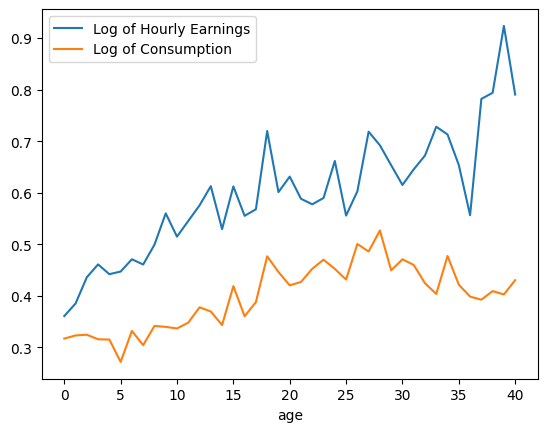

   age  log_hourly_earn  log_cons
0    0         0.360776  0.317088
1    1         0.385059  0.323238
2    2         0.436008  0.324604
3    3         0.460961  0.315802
4    4         0.441973  0.315287


In [5]:
save_this=df[["log_hourly_earn","log_cons","age"]].groupby("age").var(ddof=0).reset_index()

save_this.plot(x="age")
plt.legend(["Log of Hourly Earnings","Log of Consumption"])
plt.show()
print(save_this.head())

### Question 1.3

Simulating the model

In [6]:
ß0, ß1, ß2, ß3 = results.params.iloc[[0, 18, 19, 20]] # extracting the betas from the regression

/var/folders/m_/5q8hll8d47v2780l_9m118w00000gn/T/ipykernel_2096/2889412129.py:24: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  markov_chain = qe.markov.approximation.rouwenhorst(Nz, ρ, σ_z, mu=0.0)


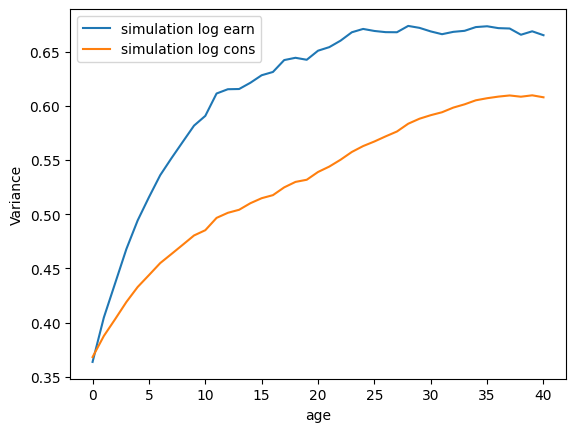

In [10]:
class modelState(object):
    def __init__(self,
                 NA=51,  # Gridpoints of assets grid
                 T=60,  # Age at death
                 Tr=45,  # Age at retirement
                 α=2.0,  # Degree of relative risk aversion
                 β=0.962,  # Discount factor
                 r=0.04,  # Interest rate
                 amin=0.0,  # Lower bound of assets'grid
                 amax=8000.0,  # Higher bound of assets'grid
                 σ=0.3638059 ** 0.5,  # Standard deviation of fixed effects
                 Nag=10000,  # Number of agents to simulate
                 σ_z=0.0386 ** 0.5,  # Standard deviation of the persistent shock z
                 ρ=0.932,  # Persistence of the persistent shock z
                 Nz=31):  # Gridpoints for the persistent income shock
        # Initialize arrays
        opt_a, opt_c = np.zeros((T, NA, Nz, 2)), np.zeros((T, NA, Nz, 2))
        y, log_y = np.zeros((T, Nz, 2)), np.zeros((T, Nz, 2))

        # Build the assets grid
        A = np.linspace(amin, amax, NA)

        # Function to construct the grid for productivity (z) using Rouwenhorst (1995)
        markov_chain = qe.markov.approximation.rouwenhorst(Nz, ρ, σ_z, mu=0.0)
        Π = markov_chain.P  # Transition matrix for z
        zgrid = markov_chain._state_values  # Grid for z

        # Now add the shocks to the second dimension of log income array
        for z in range(Nz): log_y[:, z, :] += zgrid[z]

        # Create fixed effects grid, then add its valye to the log income array
        ϵ = np.array([-σ, σ])
        log_y[:, :, 0] += ϵ[0];
        log_y[:, :, 1] += ϵ[1]

        # Create age trend for log income.
        for t in range(T): log_y[t, :, :] += 2.13+.0316*t -.0008345*t**2+ 5.98e-06*t**3

        # Adjus log income at retirement: everyone gets the same pension
        log_y[Tr:, :, :] =-2.0 

        # Fill the array of income y using the array log_income
        y = np.exp(log_y)

        # Store grids and parameters
        self.NA = NA;
        self.T = T;
        self.Tr = Tr;
        self.A = A;
        self.α = α;
        self.β = β;
        self.Π = Π;
        self.y = y;
        self.r = r;
        self.opt_a = opt_a;
        self.Nag = Nag;
        self.Nz = Nz;
        self.opt_c = opt_c;
        self.zgrid = zgrid

# Import all the parameters
st = modelState()


# Function that stores in st the policy functions for (t,iz,ie, ia=0,...,NA)
def pol_func(st, t, iz, ie):
    ce, ae = np.ones(st.NA), np.ones(st.NA)  # initialize consumption and savings

    # Find policy function (optimal savings and consumption) if t==T-1
    if (t == st.T - 1):
        st.opt_a[st.T - 1, :, iz, ie] = np.zeros(st.NA);  # Optimal savings
        st.opt_c[st.T - 1, :, iz, ie] = \
            st.A * (1 + st.r) + st.y[st.T - 1, iz, ie]  # Optimal consumption
        return

    # Find policy function (optimal savings and consumption) if t<T-1
    for ia in range(st.NA):  # Loop over assets. Note that ia=a_{t+1}...

        # Obtain expected marginal utility of cons. in t+1
        Ec = np.sum((st.opt_c[t + 1, ia, :, ie] ** -st.α) * st.Π[iz, :])

        # Use the (inverted) Euler equation to get consumption today
        ce[ia] = (Ec * (1 + st.r) * st.β) ** (-1 / st.α)

    # How much assets? Just use the (rearranged) budget constraint!
    ae = (st.A - st.y[t, iz, ie] + ce) / (1 + st.r)

    # Interpolate to have savings and consumption on the grid of assets!
    st.opt_a[t, :, iz, ie] = np.interp(st.A, ae, st.A)
    st.opt_c[t, :, iz, ie] = (1 + st.r) * st.A + st.y[t, iz, ie] - st.opt_a[t, :, iz, ie]
    return

# Compute value and policy functions for (t,iz,ie) by backward induction
for t in reversed(range(st.T)):  # Loop over (reversed) age...
    for iz in range(st.Nz):  # ...persistent income shocks iz...
        for ie in range(2):  # ...and fixed effects ie

            # Invoke"pol_func" to obtain policy functions, using the method..
            # ..of endogenous gridpoints. It solves for all assets ia=0,..,NA
            pol_func(st, t, iz, ie)
# Create fixed effect for each person
initial_states_fe = np.zeros(st.Nag, dtype=np.int32)  # initial conditions: 0 to half..
initial_states_fe[int((st.Nag) / 2):] = 1  # ..1 to the other half!

Πfe = np.array([[1.0, 0.0], [0.0, 1.0]])  # Fixed effects transition matrix

# "Simulate" the fixed effect markov chain Πfe using the routines of quant econ
mcfe = qe.MarkovChain(Πfe)
Xfe = np.transpose(mcfe.simulate(ts_length=st.T, init=initial_states_fe))

# Create the persistent income shock
initial_states_z = np.ones(st.Nag, dtype=np.int32) * \
                   int((st.Nz - 1) / 2)  # initial conditions:everyone..
# ..gets the intermediate z
# Simulate the persistent markov chain using the routines of quant econ
mc = qe.MarkovChain(st.Π)
Xz = np.transpose(mc.simulate(ts_length=st.T, init=initial_states_z))

# Initialize path of assets (this will also work as initial condition),...
# ..consumption and income
A_path, c_path, y_path = np.zeros((3, st.T, st.Nag))

# Get income given the shocks
for t in range(st.T): y_path[t, :] = st.y[t, Xz[t, :], Xfe[t, :]]

# Get savings given shocks and policy function
for t in range(st.T - 1):
    for jj in range(st.Nag):
        A_path[t + 1, jj] = np.interp(A_path[t, jj], st.A, st.opt_a[t, :, Xz[t, jj], Xfe[t, jj]])

# Use the budget constraint to get the consumption path
for t in range(st.T):
    if (t < st.T - 1):
        c_path[t, :] = (1 + st.r) * A_path[t, :] + y_path[t, :] - A_path[t + 1, :]  # work/retired
    else:
        c_path[t, :] = (1 + st.r) * A_path[t, :] + y_path[t, :]  # last period of life

# Mean assets,income and consumption over the life cycle
mA_path = np.zeros(st.T);
my_path = np.zeros(st.T);
mc_path = np.zeros(st.T)
for t in range(0, st.T): mA_path[t] = np.mean(A_path[t, :])
for t in range(0, st.T): my_path[t] = np.mean(y_path[t, :])
for t in range(0, st.T): mc_path[t] = np.mean(c_path[t, :])

# cross sectional variance log income and consumption over the life cycle
vA_path = np.zeros(st.T);
vy_path = np.zeros(st.T);
vc_path = np.zeros(st.T)
for t in range(0, st.T): vy_path[t] = np.var(np.log(y_path[t, :]))
for t in range(0, st.T): vc_path[t] = np.var(np.log(c_path[t, :]))

######
save_this=pd.DataFrame()
save_this["age"]=range(41)
save_this["simulation log earn"]=vy_path[0:41]
save_this["simulation log cons"]=vc_path[0:41]
save_this.plot(x="age")
plt.ylabel("Variance")
plt.show()

### Question 1.4

Improving the model; the first improvement that can be seen is that the intercept of the simulation is lower than the data suggests, so we increased the $\sigma^2_{\alpha}+\sigma^2_{\epsilon}$ to a higher level by trial and error. $ \sigma^2_{\alpha}$ is changed to 0.3 and $\sigma^2_{\epsilon}$ is changed to 0.02. This way the intercept has shifted upwards. 

As for the $\rho$, as STY (2001) estimates the peak of the variable $\rho$ against consumption variance at 0.98. They interpret this peak as the point where two effects offsetting each other. One effect promotes a precautionary saving behaviour where consumers insure themselves against risks and save more therefore inequality decreases, the other effect changes the shape of the curve, as $\rho$ decreases line becomes more concave meaning that rate of increase inequality is higher for young consumers with fewer savings. This rate of increase being higher increases the consumption inequality. The first effect is more dominant for the majority of the $\rho$ values until 0.98. We wanted to move to the left side of the peak where its more concave as data suggests and inequality is increasing with $\rho$.

The initial point 0.9989 remains on the right hand side of the peak where earning risk dominates the buffer stock saving behaviour, causing an increase in inequality, however as we see in the plot, the consumption behaviour is concave therefore we wanted to move to the other side of the peak in a relatively symmetric position. Therefore we chose $\rho=0.975$. 

/var/folders/m_/5q8hll8d47v2780l_9m118w00000gn/T/ipykernel_623/2792571918.py:24: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  markov_chain = qe.markov.approximation.rouwenhorst(Nz, ρ, σ_z, mu=0.0)


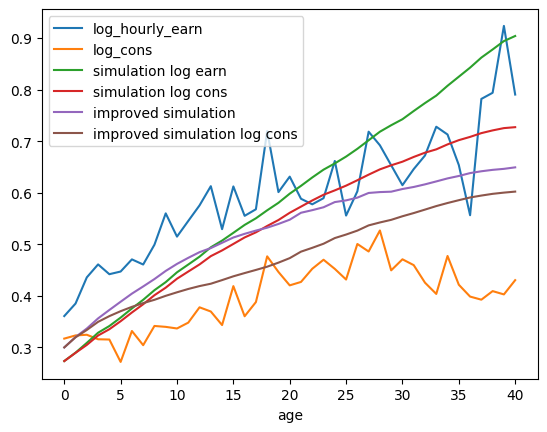

In [6]:
class modelState(object):
    def __init__(self,
                 NA=51,  # Gridpoints of assets grid
                 T=60,  # Age at death
                 Tr=45,  # Age at retirement
                 α=2.0,  # Degree of relative risk aversion
                 β=0.962,  # Disc≤ount factor
                 r=0.015,  # Interest rate
                 amin=0.0,  # Lower bound of assets'grid
                 amax=800.0,  # Higher bound of assets'grid
                 σ=0.33 ** 0.5,  # Standard deviation of fixed effects
                 Nag=10000,  # Number of agents to simulate
                 σ_z=0.02 ** 0.5,  # Standard deviation of the persistent shock z
                 ρ=0.975,  # Persistence of the persistent shock z
                 Nz=31):  # Gridpoints for the persistent income shock
        # Initialize arrays
        opt_a, opt_c = np.zeros((T, NA, Nz, 2)), np.zeros((T, NA, Nz, 2))
        y, log_y = np.zeros((T, Nz, 2)), np.zeros((T, Nz, 2))

        # Build the assets grid
        A = np.linspace(amin, amax, NA)

        # Function to construct the grid for productivity (z) using Rouwenhorst (1995)
        markov_chain = qe.markov.approximation.rouwenhorst(Nz, ρ, σ_z, mu=0.0)
        Π = markov_chain.P  # Transition matrix for z
        zgrid = markov_chain._state_values  # Grid for z

        # Now add the shocks to the second dimension of log income array
        for z in range(Nz): log_y[:, z, :] += zgrid[z]

        # Create fixed effects grid, then add its valye to the log income array
        ϵ = np.array([-σ, σ])
        log_y[:, :, 0] += ϵ[0];
        log_y[:, :, 1] += ϵ[1]

        # Create age trend for log income.
        for t in range(T): log_y[t, :, :] += ß0 + ß1 * t + ß2 * t ** 2 + ß3 * t ** 3
        # Adjus log income at retirement: everyone gets the same pension
        log_y[Tr:, :, :] = -1.0

        # Fill the array of income y using the array log_income
        y = np.exp(log_y)

        # Store grids and parameters
        self.NA = NA;
        self.T = T;
        self.Tr = Tr;
        self.A = A;
        self.α = α;
        self.β = β;
        self.Π = Π;
        self.y = y;
        self.r = r;
        self.opt_a = opt_a;
        self.Nag = Nag;
        self.Nz = Nz;
        self.opt_c = opt_c;
        self.zgrid = zgrid


# ----------------------------------------#
#     Import parameters and functions    #
# ----------------------------------------#

# Import all the parameters
st = modelState()


# Function that stores in st the policy functions for (t,iz,ie, ia=0,...,NA)
def pol_func(st, t, iz, ie):
    ce, ae = np.ones(st.NA), np.ones(st.NA)  # initialize consumption and savings

    # Find policy function (optimal savings and consumption) if t==T-1
    if (t == st.T - 1):
        st.opt_a[st.T - 1, :, iz, ie] = np.zeros(st.NA);  # Optimal savings
        st.opt_c[st.T - 1, :, iz, ie] = \
            st.A * (1 + st.r) + st.y[st.T - 1, iz, ie]  # Optimal consumption
        return

    # Find policy function (optimal savings and consumption) if t<T-1
    for ia in range(st.NA):  # Loop over assets. Note that ia=a_{t+1}...

        # Obtain expected marginal utility of cons. in t+1
        Ec = np.sum((st.opt_c[t + 1, ia, :, ie] ** -st.α) * st.Π[iz, :])

        # Use the (inverted) Euler equation to get consumption today
        ce[ia] = (Ec * (1 + st.r) * st.β) ** (-1 / st.α)

    # How much assets? Just use the (rearranged) budget constraint!
    ae = (st.A - st.y[t, iz, ie] + ce) / (1 + st.r)

    # Interpolate to have savings and consumption on the grid of assets!
    st.opt_a[t, :, iz, ie] = np.interp(st.A, ae, st.A)
    st.opt_c[t, :, iz, ie] = (1 + st.r) * st.A + st.y[t, iz, ie] - st.opt_a[t, :, iz, ie]
    return

# Compute value and policy functions for (t,iz,ie) by backward induction
for t in reversed(range(st.T)):  # Loop over (reversed) age...
    for iz in range(st.Nz):  # ...persistent income shocks iz...
        for ie in range(2):  # ...and fixed effects ie

            # Invoke"pol_func" to obtain policy functions, using the method..
            # ..of endogenous gridpoints. It solves for all assets ia=0,..,NA
            pol_func(st, t, iz, ie)

# Create fixed effect for each person
initial_states_fe = np.zeros(st.Nag, dtype=np.int32)  # initial conditions: 0 to half..
initial_states_fe[int((st.Nag) / 2):] = 1  # ..1 to the other half!

Πfe = np.array([[1.0, 0.0], [0.0, 1.0]])  # Fixed effects transition matrix

# "Simulate" the fixed effect markov chain Πfe using the routines of quant econ
mcfe = qe.MarkovChain(Πfe)
Xfe = np.transpose(mcfe.simulate(ts_length=st.T, init=initial_states_fe))

# Create the persistent income shock
initial_states_z = np.ones(st.Nag, dtype=np.int32) * \
                   int((st.Nz - 1) / 2)  # initial conditions:everyone..
# ..gets the intermediate z
# Simulate the persistent markov chain using the routines of quant econ
mc = qe.MarkovChain(st.Π)
Xz = np.transpose(mc.simulate(ts_length=st.T, init=initial_states_z))

# Initialize path of assets (this will also work as initial condition),...
# ..consumption and income
A_path, c_path, y_path = np.zeros((3, st.T, st.Nag))

# Get income given the shocks
for t in range(st.T): y_path[t, :] = st.y[t, Xz[t, :], Xfe[t, :]]

# Get savings given shocks and policy function
for t in range(st.T - 1):
    for jj in range(st.Nag):
        A_path[t + 1, jj] = np.interp(A_path[t, jj], st.A, st.opt_a[t, :, Xz[t, jj], Xfe[t, jj]])

# Use the budget constraint to get the consumption path
for t in range(st.T):
    if (t < st.T - 1):
        c_path[t, :] = (1 + st.r) * A_path[t, :] + y_path[t, :] - A_path[t + 1, :]  # work/retired
    else:
        c_path[t, :] = (1 + st.r) * A_path[t, :] + y_path[t, :]  # last period
# Mean assets,income and consumption over the life cycle
mA_path = np.zeros(st.T);
my_path = np.zeros(st.T);
mc_path = np.zeros(st.T)
for t in range(0, st.T): mA_path[t] = np.mean(A_path[t, :])
for t in range(0, st.T): my_path[t] = np.mean(y_path[t, :])
for t in range(0, st.T): mc_path[t] = np.mean(c_path[t, :])

# cross sectional variance log income and consumption over the life cycle
vA_path = np.zeros(st.T);
vy_path = np.zeros(st.T);
vc_path = np.zeros(st.T)
for t in range(0, st.T): vy_path[t] = np.var(np.log(y_path[t, :]))
for t in range(0, st.T): vc_path[t] = np.var(np.log(c_path[t, :]))

save_this["improved simulation"]=vy_path[0:41]
save_this["improved simulation log cons"]=vc_path[0:41]
save_this.plot(x="age")
plt.show()

### Question 1.5

The rise in inequality is not the same with consumption inequality becuase of the products offered by the financial markets. If the setting were an autarky, people would consume what they earned and there would be no difference between them. However consumers being rational players, they insure themselves against future flactuations in earnings via their savings and derivative products. That is why the consumption inequality is lower than the earnings inequality


### Question 1.6

Setting the risk aversion $\alpha = 1.1$ 

/var/folders/m_/5q8hll8d47v2780l_9m118w00000gn/T/ipykernel_623/653832693.py:24: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  markov_chain = qe.markov.approximation.rouwenhorst(Nz, ρ, σ_z, mu=0.0)


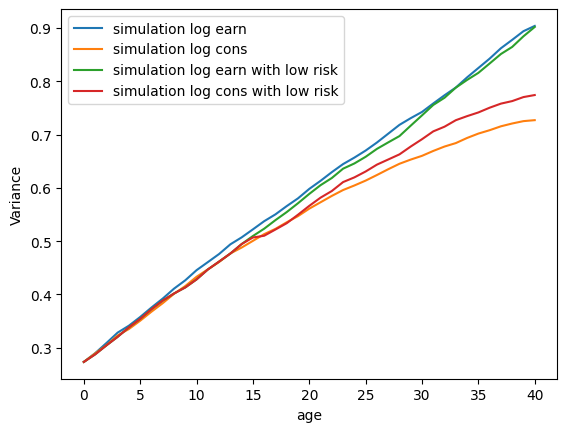

In [7]:
class modelState(object):
    def __init__(self,
                 NA=51,  # Gridpoints of assets grid
                 T=60,  # Age at death
                 Tr=45,  # Age at retirement
                 α=1.1,  # Degree of relative risk aversion
                 β=0.962,  # Discount factor
                 r=0.015,  # Interest rate
                 amin=0.0,  # Lower bound of assets'grid
                 amax=800.0,  # Higher bound of assets'grid
                 σ=0.2735 ** 0.5,  # Standard deviation of fixed effects
                 Nag=10000,  # Number of agents to simulate
                 σ_z=0.0166 ** 0.5,  # Standard deviation of the persistent shock z
                 ρ=0.9989,  # Persistence of the persistent shock z
                 Nz=31):  # Gridpoints for the persistent income shock
        # Initialize arrays
        opt_a, opt_c = np.zeros((T, NA, Nz, 2)), np.zeros((T, NA, Nz, 2))
        y, log_y = np.zeros((T, Nz, 2)), np.zeros((T, Nz, 2))

        # Build the assets grid
        A = np.linspace(amin, amax, NA)

        # Function to construct the grid for productivity (z) using Rouwenhorst (1995)
        markov_chain = qe.markov.approximation.rouwenhorst(Nz, ρ, σ_z, mu=0.0)
        Π = markov_chain.P  # Transition matrix for z
        zgrid = markov_chain._state_values  # Grid for z

        # Now add the shocks to the second dimension of log income array
        for z in range(Nz): log_y[:, z, :] += zgrid[z]

        # Create fixed effects grid, then add its valye to the log income array
        ϵ = np.array([-σ, σ])
        log_y[:, :, 0] += ϵ[0];
        log_y[:, :, 1] += ϵ[1]

        # Create age trend for log income.
        for t in range(T): log_y[t, :, :] += ß0 + ß1 * t + ß2 * t ** 2 + ß3 * t ** 3

        # Adjus log income at retirement: everyone gets the same pension
        log_y[Tr:, :, :] = -1.0

        # Fill the array of income y using the array log_income
        y = np.exp(log_y)

        # Store grids and parameters
        self.NA = NA;
        self.T = T;
        self.Tr = Tr;
        self.A = A;
        self.α = α;
        self.β = β;
        self.Π = Π;
        self.y = y;
        self.r = r;
        self.opt_a = opt_a;
        self.Nag = Nag;
        self.Nz = Nz;
        self.opt_c = opt_c;
        self.zgrid = zgrid

# Import all the parameters
st = modelState()

# Function that stores in st the policy functions for (t,iz,ie, ia=0,...,NA)
def pol_func(st, t, iz, ie):
    ce, ae = np.ones(st.NA), np.ones(st.NA)  # initialize consumption and savings

    # Find policy function (optimal savings and consumption) if t==T-1
    if (t == st.T - 1):
        st.opt_a[st.T - 1, :, iz, ie] = np.zeros(st.NA);  # Optimal savings
        st.opt_c[st.T - 1, :, iz, ie] = \
            st.A * (1 + st.r) + st.y[st.T - 1, iz, ie]  # Optimal consumption
        return

    # Find policy function (optimal savings and consumption) if t<T-1
    for ia in range(st.NA):  # Loop over assets. Note that ia=a_{t+1}...

        # Obtain expected marginal utility of cons. in t+1
        Ec = np.sum((st.opt_c[t + 1, ia, :, ie] ** -st.α) * st.Π[iz, :])

        # Use the (inverted) Euler equation to get consumption today
        ce[ia] = (Ec * (1 + st.r) * st.β) ** (-1 / st.α)

    # How much assets? Just use the (rearranged) budget constraint!
    ae = (st.A - st.y[t, iz, ie] + ce) / (1 + st.r)

    # Interpolate to have savings and consumption on the grid of assets!
    st.opt_a[t, :, iz, ie] = np.interp(st.A, ae, st.A)
    st.opt_c[t, :, iz, ie] = (1 + st.r) * st.A + st.y[t, iz, ie] - st.opt_a[t, :, iz, ie]
    return

# Compute value and policy functions for (t,iz,ie) by backward induction
for t in reversed(range(st.T)):  # Loop over (reversed) age...
    for iz in range(st.Nz):  # ...persistent income shocks iz...
        for ie in range(2):  # ...and fixed effects ie

            # Invoke"pol_func" to obtain policy functions, using the method..
            # ..of endogenous gridpoints. It solves for all assets ia=0,..,NA
            pol_func(st, t, iz, ie)
# Create fixed effect for each person
initial_states_fe = np.zeros(st.Nag, dtype=np.int32)  # initial conditions: 0 to half..
initial_states_fe[int((st.Nag) / 2):] = 1  # ..1 to the other half!

Πfe = np.array([[1.0, 0.0], [0.0, 1.0]])  # Fixed effects transition matrix

# "Simulate" the fixed effect markov chain Πfe using the routines of quant econ
mcfe = qe.MarkovChain(Πfe)
Xfe = np.transpose(mcfe.simulate(ts_length=st.T, init=initial_states_fe))

# Create the persistent income shock
initial_states_z = np.ones(st.Nag, dtype=np.int32) * \
                   int((st.Nz - 1) / 2)  # initial conditions:everyone..
# ..gets the intermediate z
# Simulate the persistent markov chain using the routines of quant econ
mc = qe.MarkovChain(st.Π)
Xz = np.transpose(mc.simulate(ts_length=st.T, init=initial_states_z))

# Initialize path of assets (this will also work as initial condition),...
# ..consumption and income
A_path, c_path, y_path = np.zeros((3, st.T, st.Nag))

# Get income given the shocks
for t in range(st.T): y_path[t, :] = st.y[t, Xz[t, :], Xfe[t, :]]

# Get savings given shocks and policy function
for t in range(st.T - 1):
    for jj in range(st.Nag):
        A_path[t + 1, jj] = np.interp(A_path[t, jj], st.A, st.opt_a[t, :, Xz[t, jj], Xfe[t, jj]])

# Use the budget constraint to get the consumption path
for t in range(st.T):
    if (t < st.T - 1):
        c_path[t, :] = (1 + st.r) * A_path[t, :] + y_path[t, :] - A_path[t + 1, :]  # work/retired
    else:
        c_path[t, :] = (1 + st.r) * A_path[t, :] + y_path[t, :]  # last period of life

# Mean assets,income and consumption over the life cycle
mA_path = np.zeros(st.T);
my_path = np.zeros(st.T);
mc_path = np.zeros(st.T)
for t in range(0, st.T): mA_path[t] = np.mean(A_path[t, :])
for t in range(0, st.T): my_path[t] = np.mean(y_path[t, :])
for t in range(0, st.T): mc_path[t] = np.mean(c_path[t, :])

# cross sectional variance log income and consumption over the life cycle
vA_path = np.zeros(st.T);
vy_path = np.zeros(st.T);
vc_path = np.zeros(st.T)
for t in range(0, st.T): vy_path[t] = np.var(np.log(y_path[t, :]))
for t in range(0, st.T): vc_path[t] = np.var(np.log(c_path[t, :]))

######
save_this.head()
save_this["simulation log earn with low risk"]=vy_path[0:41]
save_this["simulation log cons with low risk"]=vc_path[0:41]
plot_columns=["age","simulation log earn","simulation log cons",
              "simulation log earn with low risk","simulation log cons with low risk"]
save_this[plot_columns].plot(x="age")
plt.ylabel("Variance")
plt.show()

Compared to the model with $\alpha=2$ we clearly see that the difference between earnings and consumption variance decreases. This is because consumers become more tolerant to risks as $\alpha$ decreases. Consumers who can handle higher risks levels take less part in the precautionary savings behaviour therefore consume more of their income.


### Question 1.7

/var/folders/m_/5q8hll8d47v2780l_9m118w00000gn/T/ipykernel_623/3466306048.py:24: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  markov_chain = qe.markov.approximation.rouwenhorst(Nz, ρ, σ_z, mu=0.0)


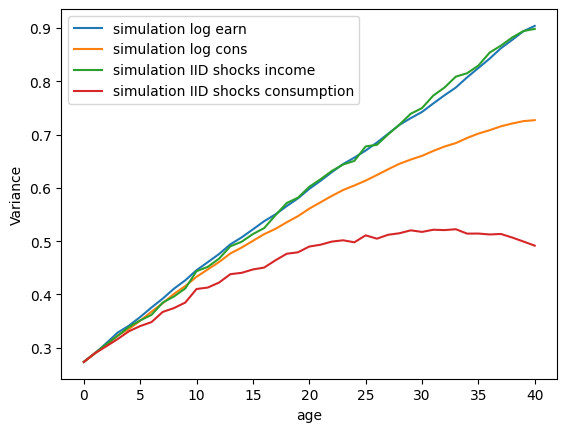

In [9]:
class modelState(object):
    def __init__(self,
                 NA=51,  # Gridpoints of assets grid
                 T=60,  # Age at death
                 Tr=45,  # Age at retirement
                 α=2.0,  # Degree of relative risk aversion
                 β=0.962,  # Discount factor
                 r=0.015,  # Interest rate
                 amin=0.0,  # Lower bound of assets'grid
                 amax=800.0,  # Higher bound of assets'grid
                 σ=0.2735 ** 0.5,  # Standard deviation of fixed effects
                 Nag=10000,  # Number of agents to simulate
                 σ_z=0.0166 ** 0.5,  # Standard deviation of the persistent shock z
                 ρ=0.9989,  # Persistence of the persistent shock z
                 Nz=31):  # Gridpoints for the persistent income shock
        # Initialize arrays
        opt_a, opt_c = np.zeros((T, NA, Nz, 2)), np.zeros((T, NA, Nz, 2))
        y, log_y = np.zeros((T, Nz, 2)), np.zeros((T, Nz, 2))

        # Build the assets grid
        A = np.linspace(amin, amax, NA)

        # Function to construct the grid for productivity (z) using Rouwenhorst (1995)
        markov_chain = qe.markov.approximation.rouwenhorst(Nz, ρ, σ_z, mu=0.0)
        Π = markov_chain.P  # Transition matrix for z
        zgrid = markov_chain._state_values  # Grid for z

        # Now add the shocks to the second dimension of log income array
        for z in range(Nz): log_y[:, z, :] += zgrid[z]

        # Create fixed effects grid, then add its valye to the log income array
        ϵ = np.array([-σ, σ])
        log_y[:, :, 0] += ϵ[0];
        log_y[:, :, 1] += ϵ[1]

        # Create age trend for log income.
        for t in range(T): log_y[t, :, :] += ß0 + ß1 * t + ß2 * t ** 2 + ß3 * t ** 3

        # Adjus log income at retirement: everyone gets the same pension
        log_y[Tr:, :, :] = -1.0

        # Fill the array of income y using the array log_income
        y = np.exp(log_y)

        # Store grids and parameters
        self.NA = NA;
        self.T = T;
        self.Tr = Tr;
        self.A = A;
        self.α = α;
        self.β = β;
        self.Π = Π;
        self.y = y;
        self.r = r;
        self.opt_a = opt_a;
        self.Nag = Nag;
        self.Nz = Nz;
        self.opt_c = opt_c;
        self.zgrid = zgrid

# Import all the parameters
st = modelState()



# Compute value and policy functions for (t,iz,ie) by backward induction
for t in reversed(range(st.T)):  
    for iz in range(st.Nz): 
        for ie in range(2): 

            pol_func(st, t, iz, ie)
# Create fixed effect for each person
initial_states_fe = np.zeros(st.Nag, dtype=np.int32)  # initial conditions: 0 to half..
initial_states_fe[int((st.Nag) / 2):] = 1  # ..1 to the other half!

Πfe = np.array([[0.5, 0.5], [0.5, 0.5]])  # Fixed effects transition matrix

# "Simulate" the fixed effect markov chain Πfe using the routines of quant econ
mcfe = qe.MarkovChain(Πfe)
Xfe = np.transpose(mcfe.simulate(ts_length=st.T, init=initial_states_fe))

# Create the persistent income shock
initial_states_z = np.ones(st.Nag, dtype=np.int32) * \
                   int((st.Nz - 1) / 2)  # initial conditions:everyone..
# ..gets the intermediate z
# Simulate the persistent markov chain using the routines of quant econ
mc = qe.MarkovChain(st.Π)
Xz = np.transpose(mc.simulate(ts_length=st.T, init=initial_states_z))

# Initialize path of assets (this will also work as initial condition),...
# ..consumption and income
A_path, c_path, y_path = np.zeros((3, st.T, st.Nag))

# Get income given the shocks
for t in range(st.T): y_path[t, :] = st.y[t, Xz[t, :], Xfe[t, :]]

# Get savings given shocks and policy function
for t in range(st.T - 1):
    for jj in range(st.Nag):
        A_path[t + 1, jj] = np.interp(A_path[t, jj], st.A, st.opt_a[t, :, Xz[t, jj], Xfe[t, jj]])

# Use the budget constraint to get the consumption path
for t in range(st.T):
    if (t < st.T - 1):
        c_path[t, :] = (1 + st.r) * A_path[t, :] + y_path[t, :] - A_path[t + 1, :]  # work/retired
    else:
        c_path[t, :] = (1 + st.r) * A_path[t, :] + y_path[t, :]  # last period of life

# Mean assets,income and consumption over the life cycle
mA_path = np.zeros(st.T);
my_path = np.zeros(st.T);
mc_path = np.zeros(st.T)
for t in range(0, st.T): mA_path[t] = np.mean(A_path[t, :])
for t in range(0, st.T): my_path[t] = np.mean(y_path[t, :])
for t in range(0, st.T): mc_path[t] = np.mean(c_path[t, :])

# cross sectional variance log income and consumption over the life cycle
vA_path = np.zeros(st.T);
vy_path = np.zeros(st.T);
vc_path = np.zeros(st.T)
for t in range(0, st.T): vy_path[t] = np.var(np.log(y_path[t, :]))
for t in range(0, st.T): vc_path[t] = np.var(np.log(c_path[t, :]))

######

save_this["simulation IID shocks income"]=vy_path[0:41]
save_this["simulation IID shocks consumption"]=vc_path[0:41]
plot_columns=["age","simulation log earn","simulation log cons",
              "simulation IID shocks income","simulation IID shocks consumption"]
save_this[plot_columns].plot(x="age")
plt.ylabel("Variance")
plt.show()

## Question 2

In the theory of the precautionary savings model as well as STY model, the financial products are seen as buffers to the income shocks. Therefore they are similar to the derivative products available in the market that allows consumers to take a reversed position to the market so that the portfolio stays the same. For example a stock owner can buy an call options contract that is when price falls he/she is not affected from the decrease, likewise consumers can insure themselves against a fall in their domestic currency's value by buying put option or a futures contract. 

However, in the models we have seen through, there are no risks attributed to these financial products nor a cost associated for purchasing such contracts. The consumers insure themselves and can buy derivatives with no cost and risk. Unfortunately these products also carry various price and default risks. As in the sub-prime crises, consumers initially benefited from cheap credits and high returns from their investments which allowed them to consume much more than their prospective incomes. Meanwhile, banks created a new kind of bonds called mortgage backed securities(MBS) and by selling them,they insured themselves assuming that mortgage market would not fail. However it failed and a large chunk of the institutions that bought MBSs, mortgages and lenders failed and went bankrupt.

To sum up, an increase in the availability of the derivatives might help the consumer better adjust themselves to the market risks. However an increase in the raw number of derivatives are not necessarily a good thing.

